## 1. Calculate Slope for 500kyr Outward Migration

Load the `jupiter_migration_outward_500kyr.pkl` file and calculate the L4/L5 ratio slope.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [12]:
# Load the 500kyr outward migration data
filename = 'jupiter_migration_outward_500kyr.pkl'

print(f'Loading data from {filename}...')
with open(filename, 'rb') as f:
    data = pickle.load(f)

# Extract data
times_saved = data['times']
snapshots_massive = data['snapshots_massive']
snapshots_planetesimals = data['snapshots_planetesimals']

print(f'Data loaded:')
print(f'  Time range: {times_saved[0]:.1f} - {times_saved[-1]:.1f} yr')
print(f'  Snapshots: {len(times_saved)}')
print(f'  Massive bodies: {len(snapshots_massive[0])}')
print(f'  Planetesimals (initial/final): {len(snapshots_planetesimals[0])}/{len(snapshots_planetesimals[-1])}')

# Check if L4/L5 counts are pre-computed
if 'l4_counts' in data and 'l5_counts' in data:
    print('  Using pre-computed L4/L5 counts')
    l4_counts_saved = data['l4_counts']
    l5_counts_saved = data['l5_counts']
else:
    print('  Computing L4/L5 counts from snapshots...')
    
    # Function to compute Trojan counts
    def compute_trojan_counts(massive_bodies, planetesimals):
        """Count planetesimals in Jupiter's L4 and L5 Trojan regions."""
        jupiter = massive_bodies[4]  # Jupiter at index 4
        
        # Extract values from AMUSE units
        jupiter_x = jupiter.x.value_in(jupiter.x.unit) if hasattr(jupiter.x, 'value_in') else jupiter.x
        jupiter_y = jupiter.y.value_in(jupiter.y.unit) if hasattr(jupiter.y, 'value_in') else jupiter.y
        jupiter_z = jupiter.z.value_in(jupiter.z.unit) if hasattr(jupiter.z, 'value_in') else jupiter.z
        
        lambda_j = np.arctan2(jupiter_y, jupiter_x)
        a_j = np.sqrt(jupiter_x**2 + jupiter_y**2 + jupiter_z**2)
        
        n_l4 = 0
        n_l5 = 0
        
        for p in planetesimals:
            # Extract particle position
            p_x = p.x.value_in(p.x.unit) if hasattr(p.x, 'value_in') else p.x
            p_y = p.y.value_in(p.y.unit) if hasattr(p.y, 'value_in') else p.y
            p_z = p.z.value_in(p.z.unit) if hasattr(p.z, 'value_in') else p.z
            
            lam = np.arctan2(p_y, p_x)
            r = np.sqrt(p_x**2 + p_y**2 + p_z**2)
            
            # Angular separation from Jupiter
            dlam = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
            
            # Co-orbital criterion: within 7% of Jupiter's semi-major axis
            is_coorb = abs(r / a_j - 1) < 0.07
            
            if is_coorb:
                # L4: +60° from Jupiter (±25° sector)
                if np.deg2rad(60-25) < dlam < np.deg2rad(60+25):
                    n_l4 += 1
                # L5: -60° from Jupiter (±25° sector)
                elif np.deg2rad(-60-25) < dlam < np.deg2rad(-60+25):
                    n_l5 += 1
        
        return n_l4, n_l5
    
    # Compute L4/L5 counts for all snapshots
    l4_counts_saved = []
    l5_counts_saved = []
    
    print('  Processing snapshots:', end=' ')
    for i, (massive, planetes) in enumerate(zip(snapshots_massive, snapshots_planetesimals)):
        if i % 20 == 0:
            print(f'{i}', end='', flush=True)
        elif i % 5 == 0:
            print('.', end='', flush=True)
        n_l4, n_l5 = compute_trojan_counts(massive, planetes)
        l4_counts_saved.append(n_l4)
        l5_counts_saved.append(n_l5)
    print(f' {len(times_saved)} done!')

print(f'  Initial L4/L5: {l4_counts_saved[0]}/{l5_counts_saved[0]}')
print(f'  Final L4/L5: {l4_counts_saved[-1]}/{l5_counts_saved[-1]}')

Loading data from jupiter_migration_outward_500kyr.pkl...
Data loaded:
  Time range: 0.0 - 500000.1 yr
  Snapshots: 1001
  Massive bodies: 8
  Planetesimals (initial/final): 10000/10000
  Computing L4/L5 counts from snapshots...
  Processing snapshots: 0Data loaded:
  Time range: 0.0 - 500000.1 yr
  Snapshots: 1001
  Massive bodies: 8
  Planetesimals (initial/final): 10000/10000
  Computing L4/L5 counts from snapshots...
  Processing snapshots: 0......2020......4040......6060......8080......100100......120120......140140......160160

KeyboardInterrupt: 

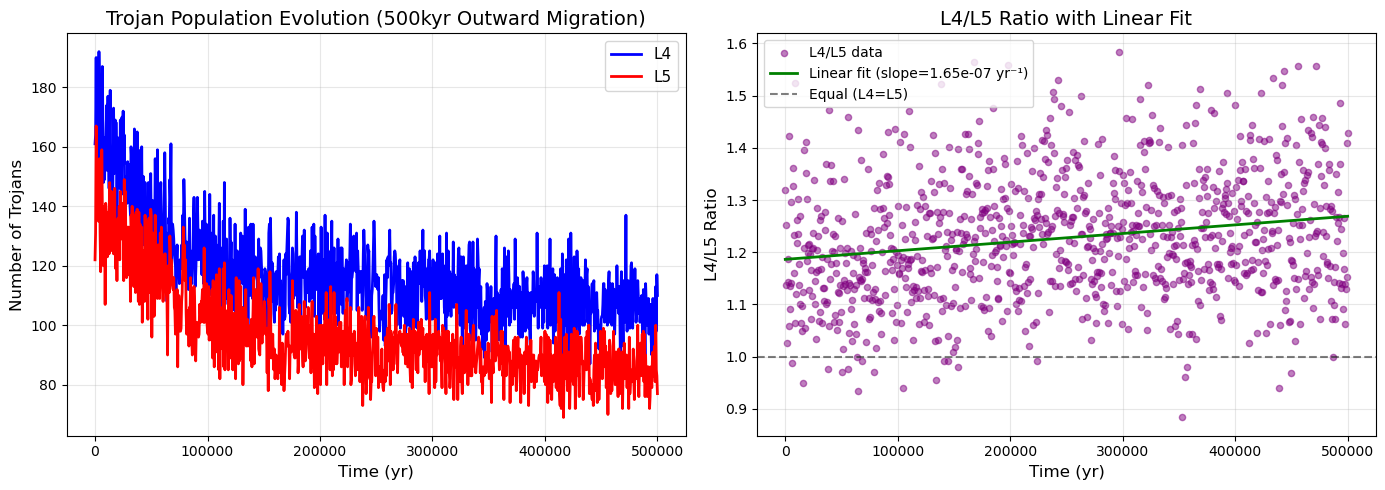

Trojan Population Summary (500kyr Outward Migration)
Initial L4: 161, L5: 122, Total: 283
Final L4: 110, L5: 77, Total: 187
L4/L5 initial ratio: 1.320
L4/L5 final ratio: 1.429
L4/L5 ratio slope: 1.652e-07 yr⁻¹
Retention: 66.1%

500kyr_out: L4/L5 ratio slope: 1.652e-07 yr⁻¹


In [9]:
# Visualize L4 and L5 Trojan populations over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: L4 and L5 counts
ax1.plot(times_saved, l4_counts_saved, 'b-', label='L4', linewidth=2)
ax1.plot(times_saved, l5_counts_saved, 'r-', label='L5', linewidth=2)
ax1.set_xlabel('Time (yr)', fontsize=12)
ax1.set_ylabel('Number of Trojans', fontsize=12)
ax1.set_title('Trojan Population Evolution (500kyr Outward Migration)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Right panel: L4/L5 ratio with fitted slope
times_array = np.array(times_saved)
l4_array = np.array(l4_counts_saved)
l5_array = np.array(l5_counts_saved)

# Calculate L4/L5 ratio
l4_l5_ratio = l4_array / (l5_array + 1e-10)

# Fit linear slope for L4/L5 ratio
ratio_slope, ratio_intercept = np.polyfit(times_array, l4_l5_ratio, 1)

# Plot data points and fitted line
ax2.scatter(times_saved, l4_l5_ratio, c='purple', alpha=0.5, s=20, label='L4/L5 data')
ax2.plot(times_saved, ratio_slope*times_array + ratio_intercept, 'g-', linewidth=2, 
         label=f'Linear fit (slope={ratio_slope:.2e} yr⁻¹)')
ax2.axhline(1.0, color='k', linestyle='--', alpha=0.5, label='Equal (L4=L5)')

ax2.set_xlabel('Time (yr)', fontsize=12)
ax2.set_ylabel('L4/L5 Ratio', fontsize=12)
ax2.set_title('L4/L5 Ratio with Linear Fit', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print('='*60)
print('Trojan Population Summary (500kyr Outward Migration)')
print('='*60)
print(f'Initial L4: {l4_counts_saved[0]}, L5: {l5_counts_saved[0]}, Total: {l4_counts_saved[0]+l5_counts_saved[0]}')
print(f'Final L4: {l4_counts_saved[-1]}, L5: {l5_counts_saved[-1]}, Total: {l4_counts_saved[-1]+l5_counts_saved[-1]}')
print(f'L4/L5 initial ratio: {l4_counts_saved[0]/(l5_counts_saved[0]+1e-10):.3f}')
print(f'L4/L5 final ratio: {l4_counts_saved[-1]/(l5_counts_saved[-1]+1e-10):.3f}')
print(f'L4/L5 ratio slope: {ratio_slope:.3e} yr⁻¹')
print(f'Retention: {100*(l4_counts_saved[-1]+l5_counts_saved[-1])/(l4_counts_saved[0]+l5_counts_saved[0]+1e-10):.1f}%')
print('='*60)

# Save the slope for later use
slope_500kyr_out = ratio_slope
print(f'\n500kyr_out: L4/L5 ratio slope: {slope_500kyr_out:.3e} yr⁻¹')

## 2. Plot Migration Duration vs L4/L5 Ratio Slope

Parse the slopes from slopes.md and create a plot showing migration duration vs slope, with linear fits for each migration type.

In [13]:
# Parse slope data from slopes.md and add the newly calculated slope
slope_data = [
    # Migration simulations - INWARD
    {'name': '50kyr_in', 'duration': 50000, 'slope': -1.830e-07, 'type': 'inward'},
    {'name': '100kyr_in', 'duration': 100000, 'slope': 1.238e-06, 'type': 'inward'},
    {'name': '500kyr_in', 'duration': 500000, 'slope': 1.477e-07, 'type': 'inward'},
    
    # Migration simulations - OUTWARD
    {'name': '50kyr_out', 'duration': 50000, 'slope': 2.481e-07, 'type': 'outward'},
    {'name': '100kyr_out', 'duration': 100000, 'slope': 2.481e-07, 'type': 'outward'},
    {'name': '500kyr_out', 'duration': 500000, 'slope': slope_500kyr_out, 'type': 'outward'},  # Newly calculated
    
    # In-situ simulations (no migration)
    {'name': '50kyr_insitu', 'duration': 50000, 'slope': 2.279e-07, 'type': 'insitu'},
    {'name': '100kyr_insitu', 'duration': 100000, 'slope': 5.468e-07, 'type': 'insitu'},
    {'name': '500kyr_insitu', 'duration': 500000, 'slope': 7.152e-08, 'type': 'insitu'},
]

# Display the data
print('='*80)
print('Migration Duration vs L4/L5 Ratio Slope Data')
print('='*80)
print(f"{'Name':<20} {'Duration (yr)':>15} {'Type':>10} {'Slope (yr⁻¹)':>15}")
print('-'*80)
for item in slope_data:
    print(f"{item['name']:<20} {item['duration']:>15,} {item['type']:>10} {item['slope']:>15.3e}")
print('='*80)

Migration Duration vs L4/L5 Ratio Slope Data
Name                   Duration (yr)       Type    Slope (yr⁻¹)
--------------------------------------------------------------------------------
50kyr_in                      50,000     inward      -1.830e-07
100kyr_in                    100,000     inward       1.238e-06
500kyr_in                    500,000     inward       1.477e-07
50kyr_out                     50,000    outward       2.481e-07
100kyr_out                   100,000    outward       2.481e-07
500kyr_out                   500,000    outward       1.652e-07
50kyr_insitu                  50,000     insitu       2.279e-07
100kyr_insitu                100,000     insitu       5.468e-07
500kyr_insitu                500,000     insitu       7.152e-08


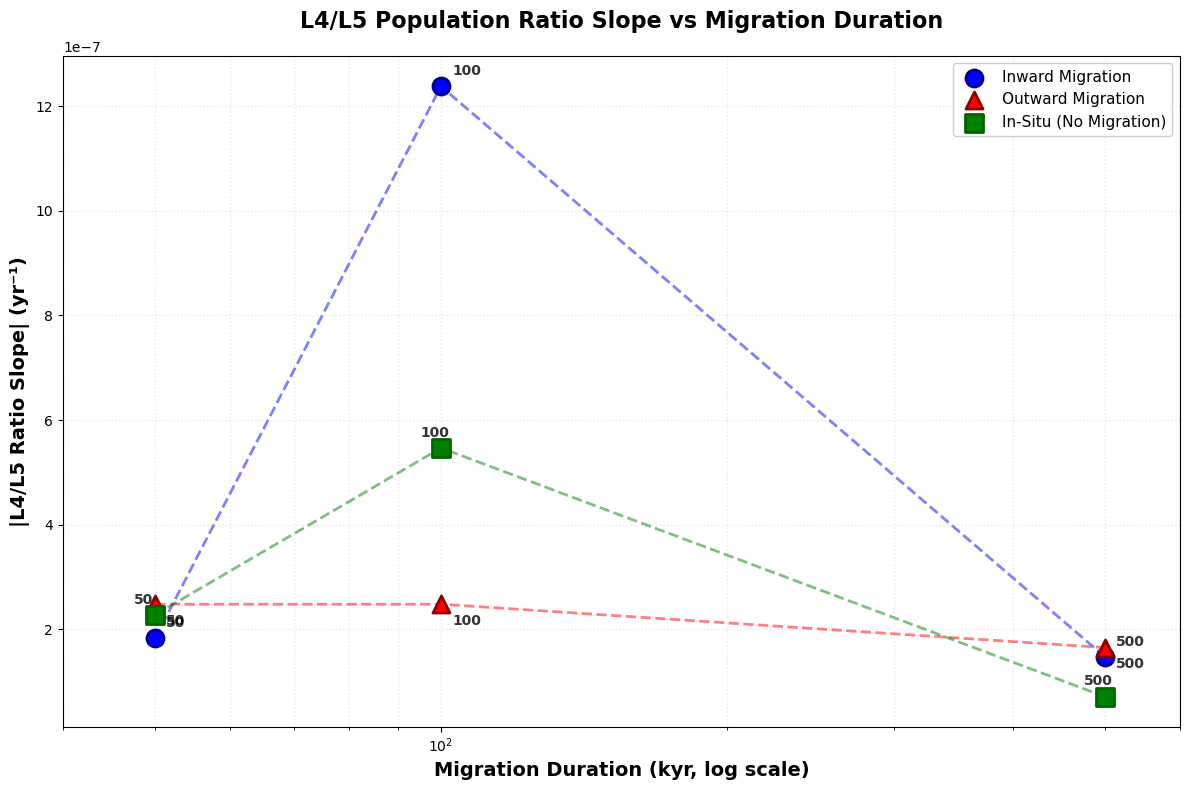

Plot created successfully!


In [17]:
# Create the plot with duration on x-axis
fig, ax = plt.subplots(figsize=(12, 8))

# Separate data by type
inward_data = sorted([d for d in slope_data if d['type'] == 'inward'], key=lambda x: x['duration'])
outward_data = sorted([d for d in slope_data if d['type'] == 'outward'], key=lambda x: x['duration'])
insitu_data = sorted([d for d in slope_data if d['type'] == 'insitu'], key=lambda x: x['duration'])

# Plot inward migration
if inward_data:
    x_in = [d['duration'] / 1000 for d in inward_data]  # Convert to kyr
    y_in = [abs(d['slope']) for d in inward_data]  # Take absolute value
    
    # Plot dashed line connecting points
    ax.plot(x_in, y_in, 'b--', linewidth=2, alpha=0.5, zorder=2)
    # Plot points on top
    ax.scatter(x_in, y_in, s=150, marker='o', color='blue', label='Inward Migration', zorder=3, edgecolors='darkblue', linewidth=2)
    
    # Add labels
    for d in inward_data:
        x = d['duration'] / 1000
        y = abs(d['slope'])
        label = d['name'].replace('_in', '').replace('kyr', '')
        ax.annotate(label, (x, y), xytext=(8, 8), textcoords='offset points', 
                   fontsize=10, alpha=0.8, fontweight='bold')

# Plot outward migration
if outward_data:
    x_out = [d['duration'] / 1000 for d in outward_data]  # Convert to kyr
    y_out = [abs(d['slope']) for d in outward_data]  # Take absolute value
    
    # Plot dashed line connecting points
    ax.plot(x_out, y_out, 'r--', linewidth=2, alpha=0.5, zorder=2)
    # Plot points on top
    ax.scatter(x_out, y_out, s=150, marker='^', color='red', label='Outward Migration', zorder=3, edgecolors='darkred', linewidth=2)
    
    # Add labels
    for d in outward_data:
        x = d['duration'] / 1000
        y = abs(d['slope'])
        label = d['name'].replace('_out', '').replace('kyr', '')
        ax.annotate(label, (x, y), xytext=(8, -15), textcoords='offset points', 
                   fontsize=10, alpha=0.8, fontweight='bold')

# Plot in-situ (no migration)
if insitu_data:
    x_insitu = [d['duration'] / 1000 for d in insitu_data]  # Convert to kyr
    y_insitu = [abs(d['slope']) for d in insitu_data]  # Take absolute value
    
    # Plot dashed line connecting points
    ax.plot(x_insitu, y_insitu, 'g--', linewidth=2, alpha=0.5, zorder=2)
    # Plot points on top
    ax.scatter(x_insitu, y_insitu, s=150, marker='s', color='green', label='In-Situ (No Migration)', zorder=3, edgecolors='darkgreen', linewidth=2)
    
    # Add labels
    for d in insitu_data:
        x = d['duration'] / 1000
        y = abs(d['slope'])
        label = d['name'].replace('_insitu', '').replace('kyr', '')
        ax.annotate(label, (x, y), xytext=(-15, 8), textcoords='offset points', 
                   fontsize=10, alpha=0.8, fontweight='bold')

# Use log scale for x-axis to better represent irregular spacing
ax.set_xscale('log')
ax.set_xlim([40, 600])  # Set limits to show all data clearly

# Labels and formatting
ax.set_xlabel('Migration Duration (kyr, log scale)', fontsize=14, fontweight='bold')
ax.set_ylabel('|L4/L5 Ratio Slope| (yr⁻¹)', fontsize=14, fontweight='bold')
ax.set_title('L4/L5 Population Ratio Slope vs Migration Duration', fontsize=16, pad=20, fontweight='bold')
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, which='both', alpha=0.3, linestyle=':', linewidth=1)

# Format y-axis in scientific notation
ax.ticklabel_format(axis='y', style='sci', scilimits=(-7,-7))

plt.tight_layout()
plt.show()

print('Plot created successfully!')

## 3. Additional Visualizations

Space for additional plots and analyses...